# MAS 651 Mid-term Project: Predicting HDL Cholesterol with Deep Learning

**GitHub Repository**: https://github.com/rvargasm7/hdl_cholesterol_prediction

**Team**: Rolando Vargas, Eleniz Espina, Bryce Leister

## Project Overview
This notebook predicts HDL cholesterol (LBDHDD_outcome) using demographic,
dietary, behavioral, and body-measure variables from the NHANES dataset.

**Target Variable:** LBDHDD_outcome (noise-perturbed Direct HDL-Cholesterol,
mg/dL)

**Data Access**: Preprocessed data available at https://github.com/rvargasm7/hdl_cholesterol_prediction/tree/main/data

### Structure:
1. Data Loading and Initial Exploration
2. Data Quality and Structure Visualization
3. Relationship Analysis
4. Predictive Analysis (Baselines + Deep Learning)
5. Model Comparison and Final Predictions

## 1. Setup and Data Loading

In [1]:
"""Install required packages if needed."""
!pip install pyreadr pandas numpy matplotlib seaborn scikit-learn xgboost catboost tensorflow keras -q

In [2]:
"""Import all required libraries for data analysis and modeling."""
import warnings
import tempfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pyreadr
from scipy import stats
from scipy.ndimage import uniform_filter1d

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    LinearRegression,
    ElasticNet,
    ElasticNetCV,
    Ridge,
    Lasso,
)
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8-whitegrid')

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
def read_rds_from_url(url):
    """Download and read RDS file from URL.

    Args:
        url: URL to the RDS file.

    Returns:
        pandas.DataFrame: The loaded data.
    """
    response = requests.get(url)
    response.raise_for_status()
    with tempfile.NamedTemporaryFile(suffix=".rds") as temp_file:
        temp_file.write(response.content)
        temp_file.flush()
        obj = pyreadr.read_r(temp_file.name)
    return list(obj.values())[0]


# Load training and test data
print("Loading data from ASASF...")
TRAIN_URL = "https://luminwin.github.io/ASASF/train.rds"
TEST_URL = "https://luminwin.github.io/ASASF/test.rds"

train_df = read_rds_from_url(TRAIN_URL)
test_df = read_rds_from_url(TEST_URL)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Loading data from ASASF...


Training data shape: (1000, 96)
Test data shape: (200, 95)


In [4]:
"""Initial data exploration."""
print("Training Data - First 5 rows:")
display(train_df.head())

Training Data - First 5 rows:


,LBDHDD_outcome,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DRD340,DRD360,DRABF,DR1MRESP,DR1HELP,WTDR2D,DRDINT,DR1TNUMF,DR1_320Z,DR1_330Z,DR1BWATZ,DR1EXMER,DR1DAY,DBQ095Z,DRQSPREP,DR1STY,DRQSDIET,DR1_300,DR1TWSZ,DR1LANG,RIAGENDR,INDFMPIR,DMDMARTZ,RIDAGEYR,RIDRETH1,RIDRETH3,BMXBMI,BMXWAIST,ALQ111,ALQ121
0,51.169706,1459.0,39.95,152.46,50.34,13.6,78.41,18.062,29.440,24.306,469.0,9.58,0.0,312.0,337.0,18.0,282.0,53.0,0.0,797.0,1.050,1.239,8.305,0.606,274.0,100.0,176.0,345.0,372.2,0.98,0.00,5.9,3.0,90.3,557.0,557.0,146.0,9.91,4.54,0.873,1565.0,1008.0,71.7,76.0,33.0,0.0,2162.40,0.169,0.127,0.081,0.187,0.225,0.771,10.724,5.151,0.557,28.522,0.270,0.000,21.479,2.252,0.001,0.015,0.003,0.004,0.000,1.0,2.0,2.0,1.0,12.0,17006.995077,2.0,17.0,1800.0,1800.0,0.0,65.0,4.0,1.0,4.0,1.0,2.0,3.0,1.0,1.0,2.0,2.17,1.0,72.0,5.0,7.0,34.3,115.1,1.0,10.0
1,64.129747,2116.0,82.54,213.12,75.49,12.7,103.08,48.495,23.529,17.248,307.0,4.58,0.0,625.0,638.0,0.0,159.0,7.0,3196.0,394.0,1.509,2.220,17.077,1.018,332.0,204.0,128.0,475.0,218.3,2.89,0.00,50.6,4.9,78.9,1090.0,1326.0,217.0,8.77,7.43,0.758,3355.0,1747.0,154.4,128.0,14.0,0.0,1492.82,1.224,1.105,1.174,2.307,4.377,7.255,21.682,7.997,1.289,22.636,0.296,0.066,13.894,1.889,0.000,0.137,0.018,0.036,0.016,2.0,1.0,2.0,1.0,12.0,23608.225881,2.0,22.0,300.0,300.0,0.0,90.0,5.0,1.0,4.0,2.0,2.0,3.0,1.0,1.0,2.0,1.03,1.0,61.0,2.0,2.0,22.6,77.3,1.0,7.0
2,43.333345,2417.0,61.59,242.22,69.35,14.7,104.62,30.182,31.087,33.534,191.0,6.13,0.0,182.0,262.0,46.0,969.0,10.0,3270.0,1014.0,1.715,1.837,21.438,1.497,312.0,153.0,161.0,418.0,217.6,3.01,0.00,31.7,1.3,117.2,678.0,930.0,237.0,12.93,10.09,1.168,3467.0,2183.0,95.3,288.0,0.0,38.1,3398.66,0.415,0.300,0.233,0.468,0.498,2.315,17.706,7.218,1.163,29.136,0.325,0.140,29.741,3.598,0.002,0.072,0.010,0.027,0.005,1.0,1.0,2.0,1.0,12.0,70055.285554,2.0,21.0,1440.0,1440.0,0.0,6.0,1.0,1.0,4.0,2.0,2.0,2.0,1.0,1.0,1.0,3.31,1.0,40.0,3.0,3.0,27.9,106.5,1.0,3.0
3,58.853188,2018.0,39.99,206.45,50.56,17.2,42.75,12.418,13.011,12.525,53.0,2.91,0.0,40.0,53.0,19.0,135.0,0.0,1098.0,168.0,1.190,0.819,13.674,0.970,274.0,195.0,79.0,410.0,176.8,1.49,0.00,5.1,0.1,62.8,403.0,789.0,206.0,11.92,7.04,0.595,3279.0,1704.0,65.1,0.0,0.0,92.7,1133.00,0.120,0.065,0.049,0.143,0.160,0.731,7.209,3.503,0.442,12.393,0.155,0.000,10.864,1.586,0.000,0.035,0.000,0.004,0.000,1.0,2.0,2.0,1.0,12.0,37889.556024,2.0,5.0,0.0,0.0,0.0,7.0,2.0,1.0,4.0,2.0,2.0,2.0,1.0,1.0,2.0,3.82,1.0,74.0,3.0,3.0,36.5,112.2,1.0,1.0
4,40.239688,2331.0,89.59,307.36,161.17,20.1,85.28,22.278,30.190,25.063,201.0,7.46,0.0,848.0,870.0,18.0,242.0,36.0,0.0,362.0,2.169,2.891,29.387,2.092,418.0,265.0,149.0,602.0,292.5,5.89,0.45,37.3,9.6,99.6,1280.0,1655.0,330.0,22.96,9.00,1.136,3269.0,3306.0,133.1,265.0,123.0,0.0,2182.59,0.274,0.208,0.132,0.313,0.379,1.384,12.566,6.462,0.792,29.325,0.246,0.015,22.146,2.584,0.001,0.064,0.014,0.009,0.078,2.0,1.0,2.0,1.0,12.0,88729.281179,2.0,20.0,120.0,120.0,0.0,65.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,2.58,2.0,80.0,3.0,3.0,24.9,102.6,1.0,8.0


In [5]:
"""Check data types and info."""
print("\nTraining Data Info:")
train_df.info()


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 96 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LBDHDD_outcome  1000 non-null   float64
 1   DR1TKCAL        1000 non-null   float64
 2   DR1TPROT        1000 non-null   float64
 3   DR1TCARB        1000 non-null   float64
 4   DR1TSUGR        1000 non-null   float64
 5   DR1TFIBE        1000 non-null   float64
 6   DR1TTFAT        1000 non-null   float64
 7   DR1TSFAT        1000 non-null   float64
 8   DR1TMFAT        1000 non-null   float64
 9   DR1TPFAT        1000 non-null   float64
 10  DR1TCHOL        1000 non-null   float64
 11  DR1TATOC        1000 non-null   float64
 12  DR1TATOA        1000 non-null   float64
 13  DR1TRET         1000 non-null   float64
 14  DR1TVARA        1000 non-null   float64
 15  DR1TACAR        1000 non-null   float64
 16  DR1TBCAR        1000 non-null   float64
 17  DR1TCRYP     

In [6]:
"""Display basic statistics."""
print("\nTraining Data Statistics:")
display(train_df.describe())


Training Data Statistics:


,LBDHDD_outcome,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DRD340,DRD360,DRABF,DR1MRESP,DR1HELP,WTDR2D,DRDINT,DR1TNUMF,DR1_320Z,DR1_330Z,DR1BWATZ,DR1EXMER,DR1DAY,DBQ095Z,DRQSPREP,DR1STY,DRQSDIET,DR1_300,DR1TWSZ,DR1LANG,RIAGENDR,INDFMPIR,DMDMARTZ,RIDAGEYR,RIDRETH1,RIDRETH3,BMXBMI,BMXWAIST,ALQ111,ALQ121
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000
mean,54.733860,2020.360000,75.083040,226.424160,96.492660,16.858100,85.609300,27.762500,28.814114,19.787024,307.359000,9.50189,0.954760,379.524000,614.014000,448.964000,2544.359000,95.136000,4071.723000,1545.751000,1.481439,1.985422,23.578046,1.917542,340.588000,128.788000,212.271000,430.533000,326.1317,4.327410,0.777390,77.666400,4.644700,124.851200,898.657000,1282.888000,299.819000,12.791000,9.82500,1.180259,3128.304000,2520.675000,103.78990,169.551000,41.055000,8.494600,3037.524160,0.470564,0.333180,0.291941,0.572348,1.140626,2.448521,15.000383,6.486573,1.165480,27.253965,0.331461,0.032239,17.460903,1.801381,0.010291,0.111169,0.048638,0.034048,0.066576,1.461000,1.280000,2.0,1.0,11.860000,52225.033109,1.883000,15.63300,1353.893070,864.176910,489.716160,50.993000,3.52300,1.781000,3.041000,1.795000,1.827000,2.104000,13.55900,1.052000,1.522000,3.315000,1.670000,54.474000,3.092000,3.233000,30.047200,102.436800,1.0,5.008000
std,9.010594,878.567665,35.072536,108.422154,66.904216,9.623927,44.880046,16.849451,15.863507,12.800487,239.663411,6.76102,3.656802,442.791205,595.237688,1087.521251,4341.809457,245.492758,7690.222915,2710.235149,0.767766,1.227318,14.424369,1.687125,176.752663,106.497948,124.757525,236.246844,185.2348,4.966136,2.768692,82.292599,5.577071,155.748667,538.338174,599.227363,144.207566,7.298416,5.51419,0.856330,1525.230154,1185.008426,53.15969,182.315908,72.382755,26.015549,1439.012747,0.467874,0.331901,0.346153,0.547048,1.839688,2.077844,8.541906,3.976183,0.949009,15.063958,0.246049,0.087422,11.440112,1.339586,0.035942,0.084870,0.191801,0.083033,0.263270,0.625196,0.481489,0.0,0.0,3.015542,60562.735258,0.321581,5.71235,1272.628369,1239.574308,877.103816,36.687586,1.75458,1.293334,1.036529,0.403904,0.378437,0.556321,30.78061,0.235269,0.499766,1.596234,3.175403,16.255201,0.866191,1.228096,6.741877,16.692296,0.0,4.594676
min,30.034304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [7]:
"""Check target variable statistics."""
TARGET_COL = 'LBDHDD_outcome'

print(f"\nTarget Variable ({TARGET_COL}):")
print(f"Mean: {train_df[TARGET_COL].mean():.2f}")
print(f"Std: {train_df[TARGET_COL].std():.2f}")
print(f"Min: {train_df[TARGET_COL].min():.2f}")
print(f"Max: {train_df[TARGET_COL].max():.2f}")
print(f"Missing: {train_df[TARGET_COL].isna().sum()}")


Target Variable (LBDHDD_outcome):
Mean: 54.73
Std: 9.01
Min: 30.03
Max: 86.71
Missing: 0


## 2. Data Quality and Structure Visualization (Task A)

### 2.1 Missingness by Feature

In [8]:
"""Calculate missing values percentage."""
missing_pct = (
    train_df.isnull().sum() / len(train_df) * 100
).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

print(f"Total features with missing values: {len(missing_pct)}")
print(f"\nTop 20 features with highest missingness:")
print(missing_pct.head(20))

Total features with missing values: 0

Top 20 features with highest missingness:
Series([], dtype: float64)


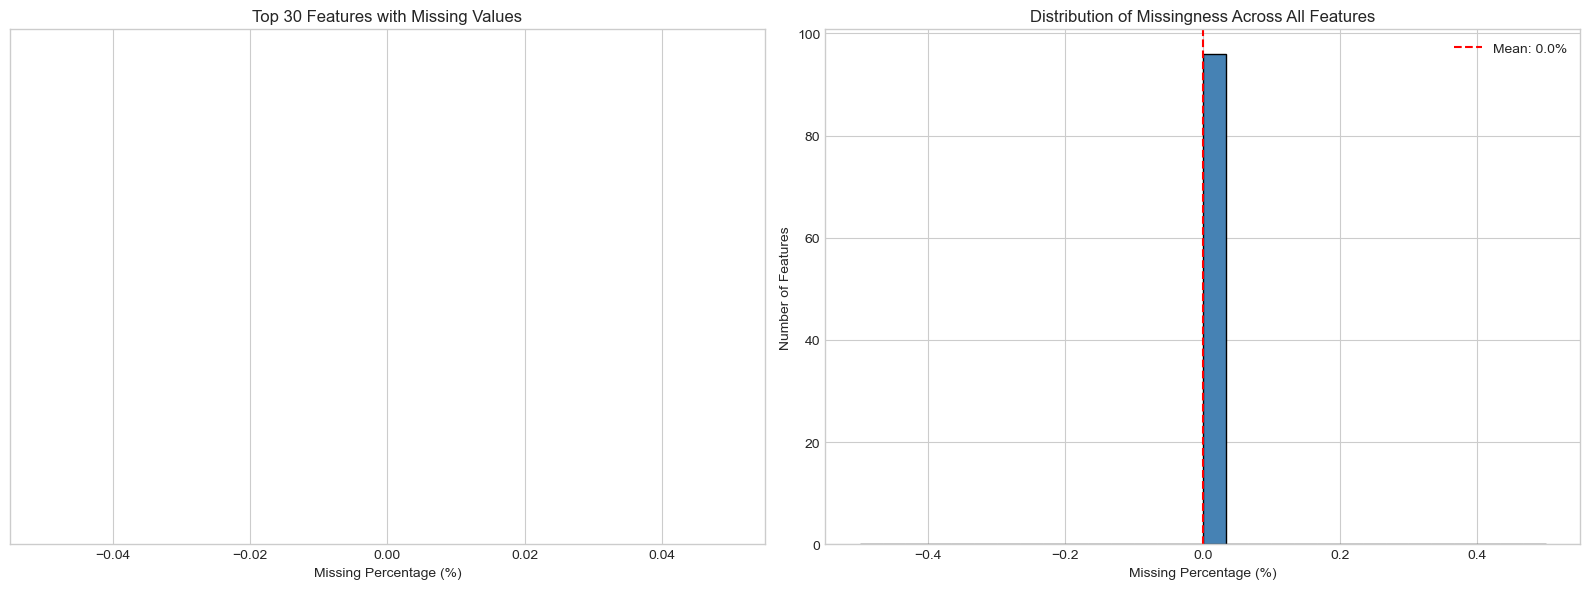

In [9]:
"""Visualize missingness patterns."""
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of top 30 missing features
top_missing = missing_pct.head(30)
axes[0].barh(range(len(top_missing)), top_missing.values, color='coral')
axes[0].set_yticks(range(len(top_missing)))
axes[0].set_yticklabels(top_missing.index, fontsize=8)
axes[0].set_xlabel('Missing Percentage (%)')
axes[0].set_title('Top 30 Features with Missing Values')
axes[0].invert_yaxis()

# Distribution of missingness across all features
all_missing = train_df.isnull().sum() / len(train_df) * 100
axes[1].hist(all_missing, bins=30, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Missing Percentage (%)')
axes[1].set_ylabel('Number of Features')
axes[1].set_title('Distribution of Missingness Across All Features')
axes[1].axvline(
    x=all_missing.mean(),
    color='red',
    linestyle='--',
    label=f'Mean: {all_missing.mean():.1f}%',
)
axes[1].legend()

plt.tight_layout()
plt.savefig('missingness_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.2 Target Distribution (Histogram + Density)

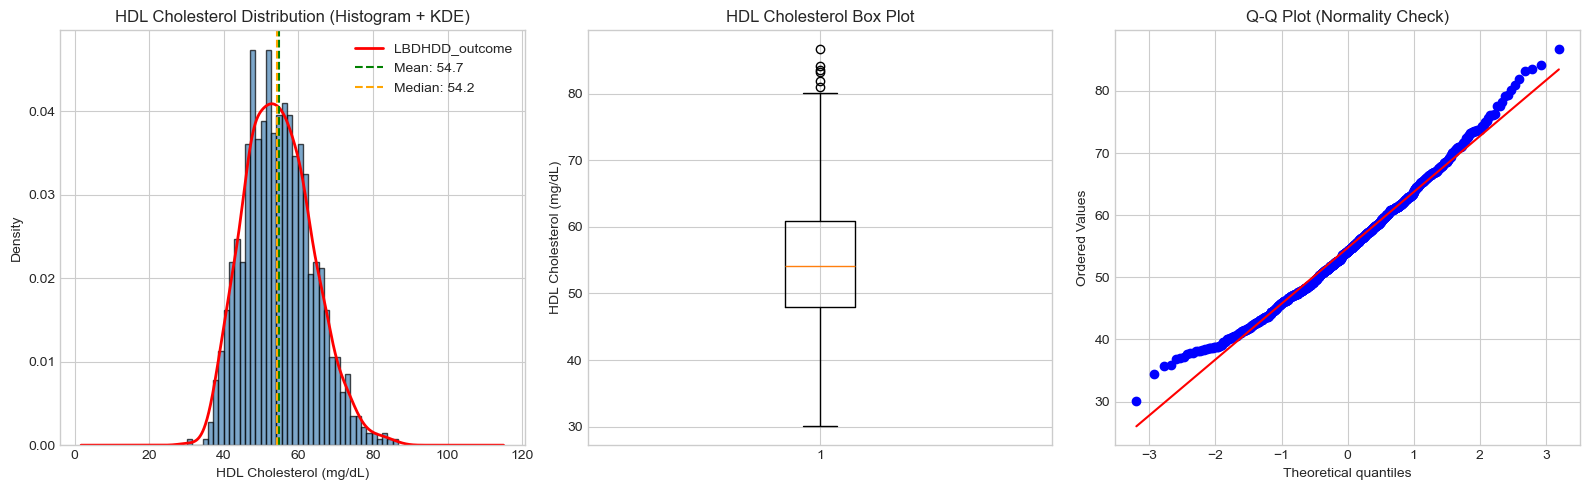


Target Distribution Statistics:
Skewness: 0.376
Kurtosis: -0.040


In [10]:
"""Visualize target variable distribution."""
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

target_data = train_df[TARGET_COL].dropna()

# Histogram with KDE
axes[0].hist(
    target_data,
    bins=40,
    density=True,
    alpha=0.7,
    color='steelblue',
    edgecolor='black',
)
target_data.plot.kde(ax=axes[0], color='red', linewidth=2)
axes[0].set_xlabel('HDL Cholesterol (mg/dL)')
axes[0].set_ylabel('Density')
axes[0].set_title('HDL Cholesterol Distribution (Histogram + KDE)')
axes[0].axvline(
    target_data.mean(),
    color='green',
    linestyle='--',
    label=f'Mean: {target_data.mean():.1f}',
)
axes[0].axvline(
    target_data.median(),
    color='orange',
    linestyle='--',
    label=f'Median: {target_data.median():.1f}',
)
axes[0].legend()

# Box plot
axes[1].boxplot(target_data, vert=True)
axes[1].set_ylabel('HDL Cholesterol (mg/dL)')
axes[1].set_title('HDL Cholesterol Box Plot')

# Q-Q plot
stats.probplot(target_data, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)')

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Skewness and Kurtosis
print(f"\nTarget Distribution Statistics:")
print(f"Skewness: {target_data.skew():.3f}")
print(f"Kurtosis: {target_data.kurtosis():.3f}")

### 2.3 Correlation Heatmap for Top Correlated Numeric Features

In [11]:
"""Calculate correlations with target variable."""
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Number of numeric features: {len(numeric_cols)}")

# Calculate correlations with target
correlations = (
    train_df[numeric_cols]
    .corr()[TARGET_COL]
    .drop(TARGET_COL)
    .abs()
    .sort_values(ascending=False)
)
print(f"\nTop 20 features correlated with HDL:")
print(correlations.head(20))

Number of numeric features: 96

Top 20 features correlated with HDL:
BMXWAIST    0.595812
RIAGENDR    0.522740
BMXBMI      0.483975
DR1TNUMF    0.188157
DR1TALCO    0.170589
INDFMPIR    0.169201
DR1BWATZ    0.164396
DR1TVK      0.156818
DR1TVC      0.156080
DR1TLZ      0.141205
DR1TP204    0.135297
DR1TBCAR    0.133542
DR1TSUGR    0.133169
DR1TCARB    0.129983
DRQSPREP    0.117522
DR1TFF      0.116210
DR1TS180    0.107544
DR1TM161    0.097463
DR1TPROT    0.096097
DR1TCRYP    0.095674
Name: LBDHDD_outcome, dtype: float64


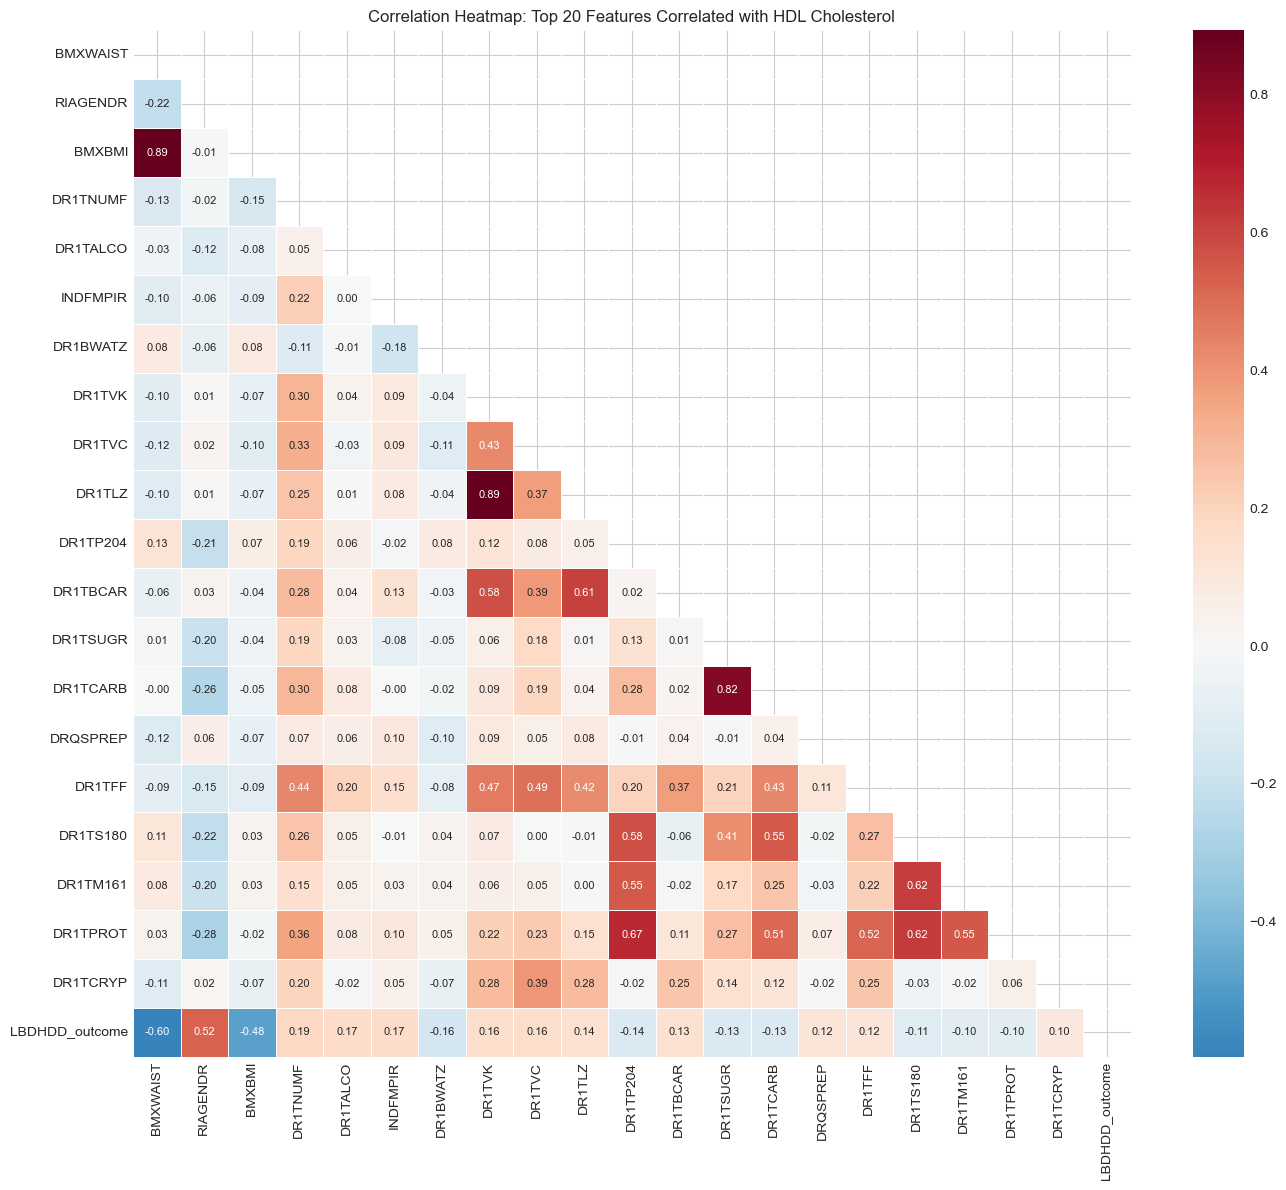

In [12]:
"""Create correlation heatmap for top correlated features."""
top_features = correlations.head(20).index.tolist()
top_features.append(TARGET_COL)

corr_matrix = train_df[top_features].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    linewidths=0.5,
    annot_kws={'size': 8},
)
plt.title(
    'Correlation Heatmap: Top 20 Features Correlated with HDL Cholesterol',
    fontsize=12,
)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Relationships Visualization (Task B)

### 3.1 HDL vs BMI (Scatter + Trend Line)

In [13]:
"""Find BMI and body measurement columns."""
bmi_cols = [
    col for col in train_df.columns
    if 'BMI' in col.upper() or 'bmi' in col.lower()
]
print(f"BMI-related columns found: {bmi_cols}")

body_cols = [
    col for col in train_df.columns
    if 'BMX' in col or 'body' in col.lower()
]
print(f"Body measurement columns: {body_cols[:20]}")

BMI-related columns found: ['BMXBMI']
Body measurement columns: ['BMXBMI', 'BMXWAIST']


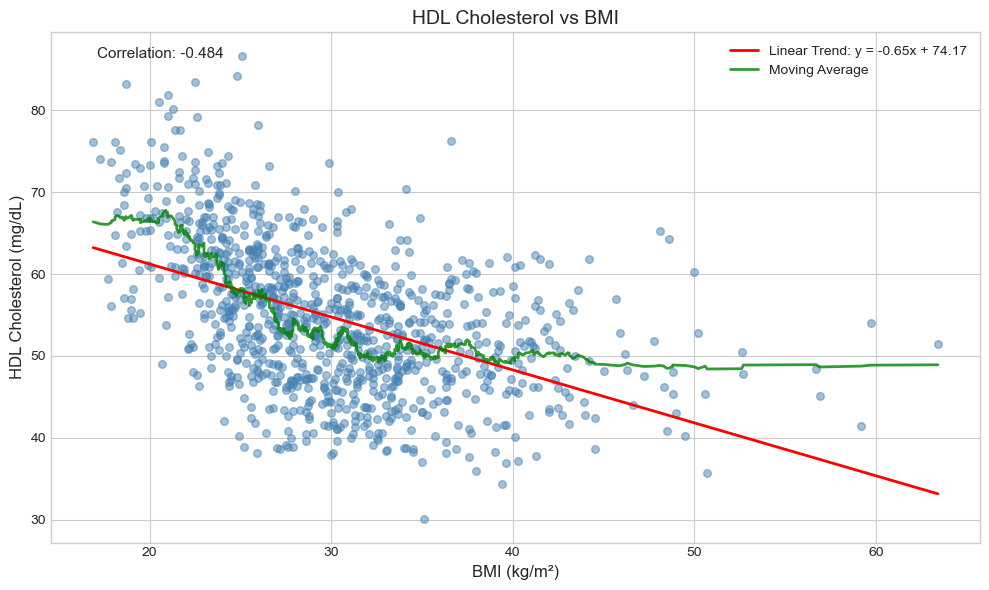

In [14]:
def find_column_by_patterns(df, patterns):
    """Find a column matching any of the given patterns.

    Args:
        df: DataFrame to search.
        patterns: List of patterns to match.

    Returns:
        str or None: Matching column name or None.
    """
    for col in df.columns:
        for pattern in patterns:
            if pattern in col.upper():
                return col
    return None


# Find BMI column
bmi_col = find_column_by_patterns(train_df, ['BMXBMI', 'BMI'])

if bmi_col:
    fig, ax = plt.subplots(figsize=(10, 6))

    valid_data = train_df[[bmi_col, TARGET_COL]].dropna()

    # Scatter plot
    ax.scatter(
        valid_data[bmi_col],
        valid_data[TARGET_COL],
        alpha=0.5,
        c='steelblue',
        s=30,
    )

    # Trend line (linear regression)
    coefficients = np.polyfit(
        valid_data[bmi_col],
        valid_data[TARGET_COL],
        1,
    )
    poly = np.poly1d(coefficients)
    x_line = np.linspace(
        valid_data[bmi_col].min(),
        valid_data[bmi_col].max(),
        100,
    )
    ax.plot(
        x_line,
        poly(x_line),
        'r-',
        linewidth=2,
        label=f'Linear Trend: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}',
    )

    # Add moving average smoothing
    sorted_idx = valid_data[bmi_col].argsort()
    x_sorted = valid_data[bmi_col].iloc[sorted_idx]
    y_sorted = valid_data[TARGET_COL].iloc[sorted_idx]
    y_smooth = uniform_filter1d(y_sorted, size=50)
    ax.plot(
        x_sorted,
        y_smooth,
        'g-',
        linewidth=2,
        alpha=0.8,
        label='Moving Average',
    )

    ax.set_xlabel('BMI (kg/m²)', fontsize=12)
    ax.set_ylabel('HDL Cholesterol (mg/dL)', fontsize=12)
    ax.set_title('HDL Cholesterol vs BMI', fontsize=14)
    ax.legend()

    # Add correlation annotation
    corr = valid_data[bmi_col].corr(valid_data[TARGET_COL])
    ax.annotate(
        f'Correlation: {corr:.3f}',
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=11,
    )

    plt.tight_layout()
    plt.savefig('hdl_vs_bmi.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("BMI column not found in the dataset")

### 3.2 HDL by Subgroups (Box/Violin Plots)

In [15]:
"""Find categorical columns for subgroup analysis."""
cat_cols = train_df.select_dtypes(
    include=['object', 'category']
).columns.tolist()
print(f"Categorical columns: {cat_cols}")

# Check for potential demographic columns
demo_keywords = [
    'SEX', 'GENDER', 'RACE', 'ETHNIC', 'SMOKE', 'AGE', 'RIDRETH', 'SMQ',
]
potential_demo = [
    col for col in train_df.columns
    if any(kw in col.upper() for kw in demo_keywords)
]
print(f"\nPotential demographic columns: {potential_demo}")

Categorical columns: []

Potential demographic columns: ['RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'RIDRETH3']


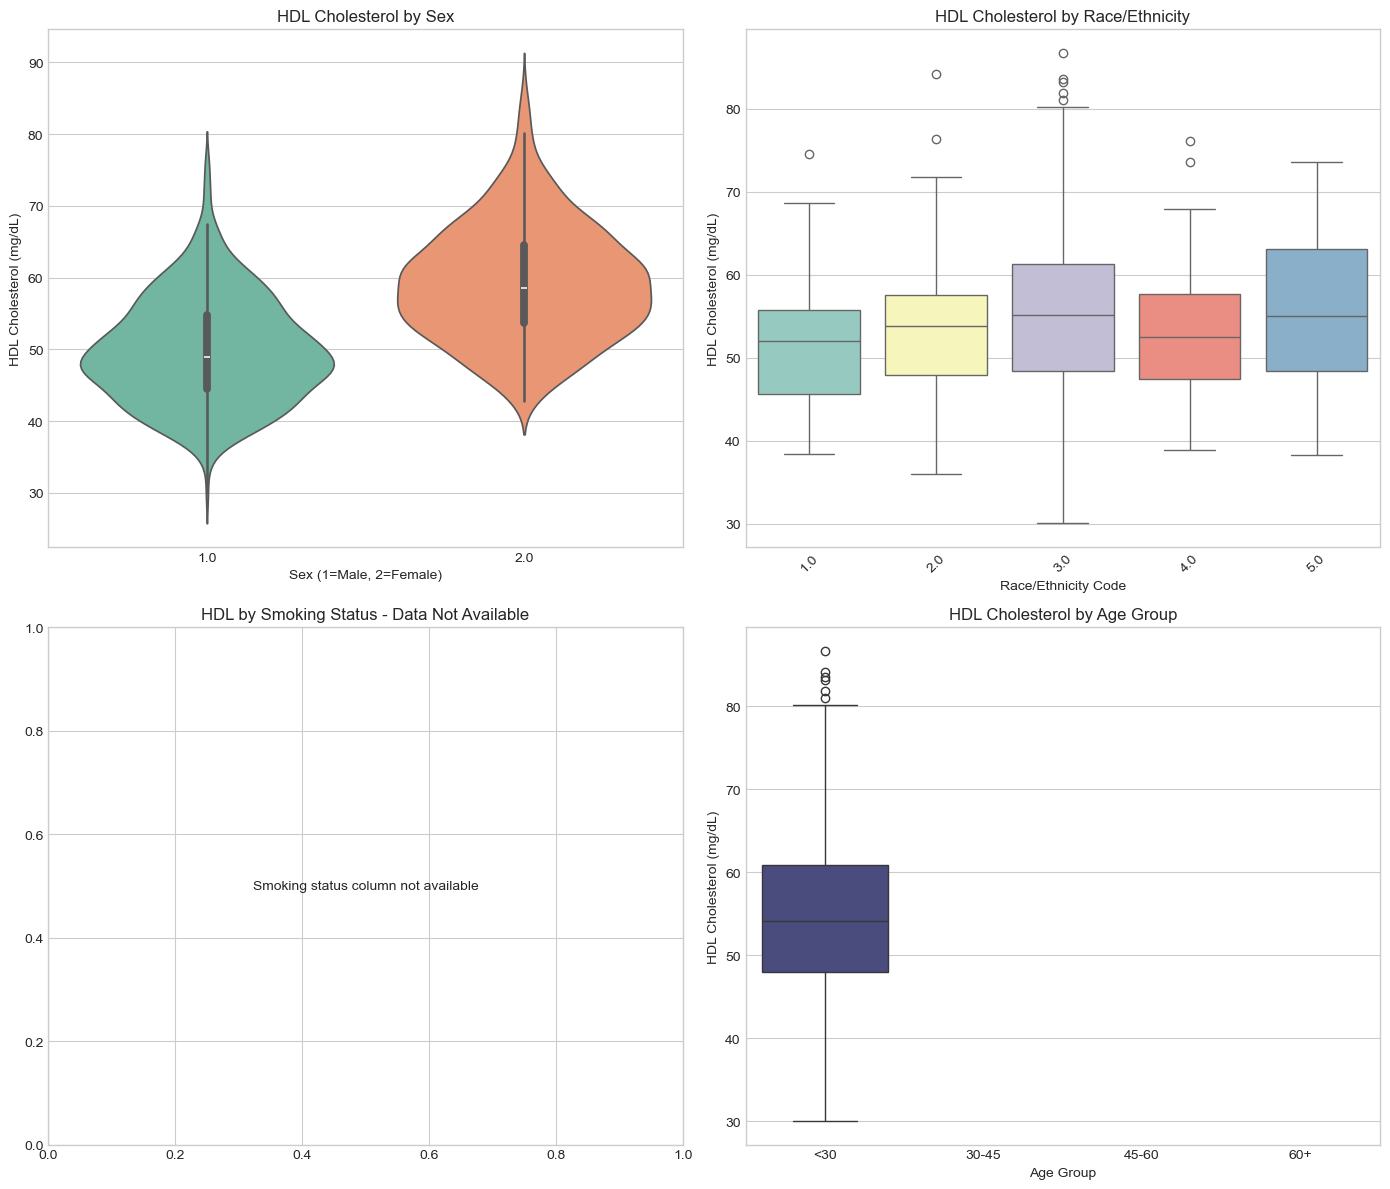

In [16]:
"""Create subgroup visualizations."""
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Find relevant demographic columns
sex_col = find_column_by_patterns(train_df, ['RIAGENDR', 'SEX'])
race_col = find_column_by_patterns(train_df, ['RIDRETH'])
smoke_col = find_column_by_patterns(train_df, ['SMQ020', 'SMOKE'])
age_col = find_column_by_patterns(train_df, ['RIDAGEYR', 'AGE'])

# Plot 1: HDL by Sex
if sex_col and sex_col in train_df.columns:
    data = train_df[[sex_col, TARGET_COL]].dropna()
    if len(data) > 0:
        sns.violinplot(
            data=data,
            x=sex_col,
            y=TARGET_COL,
            ax=axes[0, 0],
            palette='Set2',
        )
        axes[0, 0].set_title('HDL Cholesterol by Sex')
        axes[0, 0].set_xlabel('Sex (1=Male, 2=Female)')
        axes[0, 0].set_ylabel('HDL Cholesterol (mg/dL)')
else:
    axes[0, 0].text(
        0.5, 0.5,
        'Sex column not available',
        ha='center',
        va='center',
    )
    axes[0, 0].set_title('HDL by Sex - Data Not Available')

# Plot 2: HDL by Race/Ethnicity
if race_col and race_col in train_df.columns:
    data = train_df[[race_col, TARGET_COL]].dropna()
    if len(data) > 0:
        sns.boxplot(
            data=data,
            x=race_col,
            y=TARGET_COL,
            ax=axes[0, 1],
            palette='Set3',
        )
        axes[0, 1].set_title('HDL Cholesterol by Race/Ethnicity')
        axes[0, 1].set_xlabel('Race/Ethnicity Code')
        axes[0, 1].set_ylabel('HDL Cholesterol (mg/dL)')
        axes[0, 1].tick_params(axis='x', rotation=45)
else:
    axes[0, 1].text(
        0.5, 0.5,
        'Race/Ethnicity column not available',
        ha='center',
        va='center',
    )
    axes[0, 1].set_title('HDL by Race/Ethnicity - Data Not Available')

# Plot 3: HDL by Smoking Status
if smoke_col and smoke_col in train_df.columns:
    data = train_df[[smoke_col, TARGET_COL]].dropna()
    if len(data) > 0:
        sns.violinplot(
            data=data,
            x=smoke_col,
            y=TARGET_COL,
            ax=axes[1, 0],
            palette='coolwarm',
        )
        axes[1, 0].set_title('HDL Cholesterol by Smoking Status')
        axes[1, 0].set_xlabel('Smoking Status')
        axes[1, 0].set_ylabel('HDL Cholesterol (mg/dL)')
else:
    axes[1, 0].text(
        0.5, 0.5,
        'Smoking status column not available',
        ha='center',
        va='center',
    )
    axes[1, 0].set_title('HDL by Smoking Status - Data Not Available')

# Plot 4: HDL by Age Groups
if age_col and age_col in train_df.columns:
    data = train_df[[age_col, TARGET_COL]].dropna().copy()
    if len(data) > 0:
        data['Age_Group'] = pd.cut(
            data[age_col],
            bins=[0, 30, 45, 60, 100],
            labels=['<30', '30-45', '45-60', '60+'],
        )
        sns.boxplot(
            data=data,
            x='Age_Group',
            y=TARGET_COL,
            ax=axes[1, 1],
            palette='viridis',
        )
        axes[1, 1].set_title('HDL Cholesterol by Age Group')
        axes[1, 1].set_xlabel('Age Group')
        axes[1, 1].set_ylabel('HDL Cholesterol (mg/dL)')
else:
    axes[1, 1].text(
        0.5, 0.5,
        'Age column not available',
        ha='center',
        va='center',
    )
    axes[1, 1].set_title('HDL by Age Group - Data Not Available')

plt.tight_layout()
plt.savefig('hdl_by_subgroups.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Diet/Nutrient Intake vs HDL

In [17]:
"""Find dietary/nutrient columns."""
nutrient_keywords = [
    'DR', 'DIET', 'CALOR', 'FAT', 'PROTEIN',
    'CARB', 'FIBER', 'SUGAR', 'SODIUM', 'CHOL',
]
nutrient_cols = [
    col for col in train_df.columns
    if any(kw in col.upper() for kw in nutrient_keywords)
    and col != TARGET_COL
]
print(f"Nutrient-related columns found: {len(nutrient_cols)}")
print(nutrient_cols[:20])

Nutrient-related columns found: 87
['DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL', 'DR1TATOC', 'DR1TATOA', 'DR1TRET', 'DR1TVARA', 'DR1TACAR', 'DR1TBCAR', 'DR1TCRYP', 'DR1TLYCO', 'DR1TLZ', 'DR1TVB1']


Top 4 correlated nutrient variables: ['RIAGENDR', 'DR1TNUMF', 'DR1TALCO', 'DR1BWATZ']


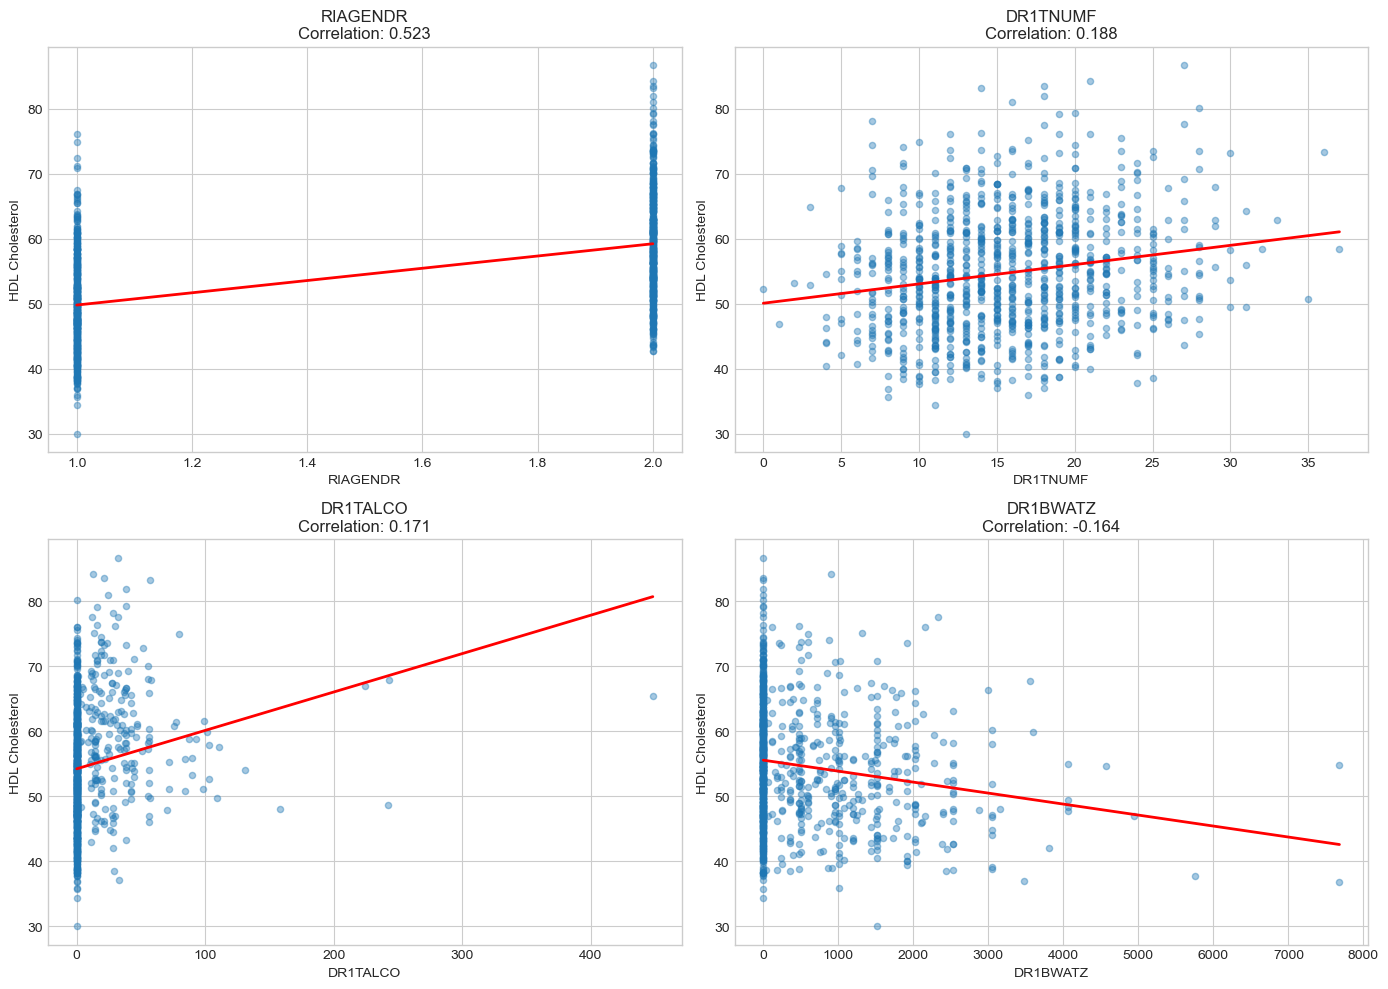

In [18]:
"""Visualize relationships between nutrients and HDL."""
if nutrient_cols:
    # Calculate correlations with target
    nutrient_corrs = (
        train_df[nutrient_cols + [TARGET_COL]]
        .corr()[TARGET_COL]
        .drop(TARGET_COL)
        .abs()
        .sort_values(ascending=False)
    )
    top_nutrients = nutrient_corrs.head(4).index.tolist()
    print(f"Top 4 correlated nutrient variables: {top_nutrients}")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, col in enumerate(top_nutrients):
        if i < 4:
            valid_data = train_df[[col, TARGET_COL]].dropna()
            if len(valid_data) > 10:
                # Scatter plot
                axes[i].scatter(
                    valid_data[col],
                    valid_data[TARGET_COL],
                    alpha=0.4,
                    s=20,
                )

                # Trend line
                coeffs = np.polyfit(
                    valid_data[col],
                    valid_data[TARGET_COL],
                    1,
                )
                poly = np.poly1d(coeffs)
                x_line = np.linspace(
                    valid_data[col].min(),
                    valid_data[col].max(),
                    100,
                )
                axes[i].plot(x_line, poly(x_line), 'r-', linewidth=2)

                corr = valid_data[col].corr(valid_data[TARGET_COL])
                axes[i].set_title(f'{col}\nCorrelation: {corr:.3f}')
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('HDL Cholesterol')

    plt.tight_layout()
    plt.savefig('hdl_vs_nutrients.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No nutrient columns found")

### 3.4 Waist Circumference vs HDL

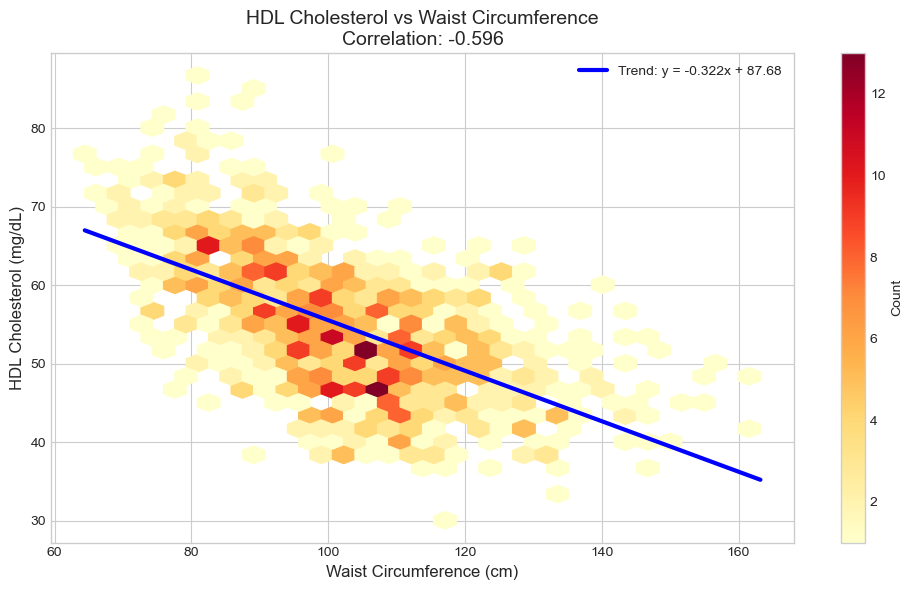

In [19]:
"""Visualize waist circumference vs HDL relationship."""
waist_col = find_column_by_patterns(train_df, ['BMXWAIST', 'WAIST'])

if waist_col:
    fig, ax = plt.subplots(figsize=(10, 6))

    valid_data = train_df[[waist_col, TARGET_COL]].dropna()

    # Hexbin plot for density visualization
    hb = ax.hexbin(
        valid_data[waist_col],
        valid_data[TARGET_COL],
        gridsize=30,
        cmap='YlOrRd',
        mincnt=1,
    )
    plt.colorbar(hb, ax=ax, label='Count')

    # Trend line
    coeffs = np.polyfit(
        valid_data[waist_col],
        valid_data[TARGET_COL],
        1,
    )
    poly = np.poly1d(coeffs)
    x_line = np.linspace(
        valid_data[waist_col].min(),
        valid_data[waist_col].max(),
        100,
    )
    ax.plot(
        x_line,
        poly(x_line),
        'b-',
        linewidth=3,
        label=f'Trend: y = {coeffs[0]:.3f}x + {coeffs[1]:.2f}',
    )

    corr = valid_data[waist_col].corr(valid_data[TARGET_COL])
    ax.set_xlabel('Waist Circumference (cm)', fontsize=12)
    ax.set_ylabel('HDL Cholesterol (mg/dL)', fontsize=12)
    ax.set_title(
        f'HDL Cholesterol vs Waist Circumference\nCorrelation: {corr:.3f}',
        fontsize=14,
    )
    ax.legend()

    plt.tight_layout()
    plt.savefig('hdl_vs_waist.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Waist circumference column not found")
    body_measures = [col for col in train_df.columns if 'BMX' in col]
    print(f"Available body measurement columns: {body_measures}")

## 4. Predictive Analysis (Task C)

### 4.1 Data Preprocessing

In [20]:
"""Prepare features and target for modeling."""
# Separate features and target
X = train_df.drop(columns=[TARGET_COL])
y = train_df[TARGET_COL]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (1000, 95)
Target shape: (1000,)


In [21]:
"""Identify column types for preprocessing."""
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(
    include=['object', 'category']
).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

Numeric features: 95
Categorical features: 0


In [22]:
"""Create preprocessing pipelines."""
# Numeric preprocessing: impute with median, then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

# Categorical preprocessing: impute with most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

In [23]:
"""Split data into train and validation sets."""
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 800
Validation set size: 200


In [24]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display model performance metrics.

    Args:
        y_true: True target values.
        y_pred: Predicted values.
        model_name: Name of the model for display.

    Returns:
        dict: Dictionary with model metrics.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Results:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")

    return {'model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}


# Store results for comparison
results = []

### 4.2 Baseline Models

#### 4.2.1 Linear Regression

In [25]:
"""Train and evaluate Linear Regression model."""
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression()),
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_lr, 'Linear Regression'))


Linear Regression Results:
  RMSE: 5.9322
  MAE:  4.6188
  R²:   0.5778


#### 4.2.2 Ridge Regression

In [26]:
"""Train and evaluate Ridge Regression model."""
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0)),
])

ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_ridge, 'Ridge Regression'))


Ridge Regression Results:
  RMSE: 5.9012
  MAE:  4.5957
  R²:   0.5822


#### 4.2.3 Elastic Net

In [27]:
"""Train and evaluate Elastic Net model."""
elastic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)),
])

elastic_pipeline.fit(X_train, y_train)
y_pred_elastic = elastic_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_elastic, 'Elastic Net'))


Elastic Net Results:
  RMSE: 5.8996
  MAE:  4.6086
  R²:   0.5825


#### 4.2.4 Random Forest

In [28]:
"""Train and evaluate Random Forest model."""
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )),
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_rf, 'Random Forest'))


Random Forest Results:
  RMSE: 5.1581
  MAE:  4.0554
  R²:   0.6808


#### 4.2.5 Gradient Boosting

In [29]:
"""Train and evaluate Gradient Boosting model."""
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
    )),
])

gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_gb, 'Gradient Boosting'))


Gradient Boosting Results:
  RMSE: 5.2716
  MAE:  4.1297
  R²:   0.6666


#### 4.2.6 XGBoost

In [30]:
"""Train and evaluate XGBoost model."""
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0,
    )),
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_xgb, 'XGBoost'))


XGBoost Results:
  RMSE: 5.3640
  MAE:  4.2073
  R²:   0.6548


#### 4.2.7 CatBoost

In [31]:
"""Train and evaluate CatBoost model."""
catboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(
        iterations=200,
        depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        verbose=0,
    )),
])

catboost_pipeline.fit(X_train, y_train)
y_pred_catboost = catboost_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_catboost, 'CatBoost'))


CatBoost Results:
  RMSE: 5.2075
  MAE:  4.1282
  R²:   0.6747


### 4.3 Deep Learning Model (Tabular Neural Network)

In [32]:
"""Prepare data for neural network."""
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed validation data shape: {X_val_processed.shape}")

Processed training data shape: (800, 95)
Processed validation data shape: (200, 95)


In [33]:
def build_tabular_nn(input_dim, learning_rate=0.001):
    """Build a tabular neural network for regression.

    Architecture:
    - Input layer
    - Dense layers with BatchNormalization and Dropout
    - Output layer (single neuron for regression)

    Args:
        input_dim: Number of input features.
        learning_rate: Learning rate for Adam optimizer.

    Returns:
        keras.Model: Compiled neural network model.
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),

        # First hidden block
        layers.Dense(256, kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        # Second hidden block
        layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        # Third hidden block
        layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        # Fourth hidden block
        layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.1),

        # Output layer
        layers.Dense(1),
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


# Build model
nn_model = build_tabular_nn(X_train_processed.shape[1])
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,761 (272.50 KB)

 Trainable params: 68,801 (268.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [34]:
"""Define callbacks and train the neural network."""
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1,
)

# Train the model
history = nn_model.fit(
    X_train_processed,
    y_train,
    validation_data=(X_val_processed, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

Epoch 1/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 16s 693ms/step - loss: 3143.0188 - mae: 55.1380

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3137.3203 - mae: 55.2423   

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3090.3169 - mae: 54.8580 - val_loss: 3237.1731 - val_mae: 56.1537 - learning_rate: 0.0010


Epoch 2/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3085.4746 - mae: 54.6019

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3029.6721 - mae: 54.3329 - val_loss: 3195.7266 - val_mae: 55.7879 - learning_rate: 0.0010


Epoch 3/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3019.0034 - mae: 54.0150

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2976.4993 - mae: 53.8510 - val_loss: 3173.6843 - val_mae: 55.5944 - learning_rate: 0.0010


Epoch 4/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2970.0537 - mae: 53.6505

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2914.5212 - mae: 53.3101 - val_loss: 3129.4255 - val_mae: 55.2181 - learning_rate: 0.0010


Epoch 5/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2924.7996 - mae: 53.2149

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2854.8518 - mae: 52.7741 - val_loss: 3091.0042 - val_mae: 54.8937 - learning_rate: 0.0010


Epoch 6/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2842.6946 - mae: 52.5444

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2792.9043 - mae: 52.2316 - val_loss: 3012.8062 - val_mae: 54.2195 - learning_rate: 0.0010


Epoch 7/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2780.7578 - mae: 51.9487

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2720.2954 - mae: 51.5780 - val_loss: 2927.8616 - val_mae: 53.4958 - learning_rate: 0.0010


Epoch 8/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2719.7334 - mae: 51.3879

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2652.9092 - mae: 50.9694 - val_loss: 2847.2861 - val_mae: 52.7969 - learning_rate: 0.0010


Epoch 9/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2648.6704 - mae: 50.7682

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2575.5352 - mae: 50.2643 - val_loss: 2714.2622 - val_mae: 51.5777 - learning_rate: 0.0010


Epoch 10/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2554.6301 - mae: 49.9082

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2499.6411 - mae: 49.5384 - val_loss: 2591.0986 - val_mae: 50.4168 - learning_rate: 0.0010


Epoch 11/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2475.2224 - mae: 49.0641

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2414.3984 - mae: 48.6990 - val_loss: 2498.1631 - val_mae: 49.5056 - learning_rate: 0.0010


Epoch 12/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2384.3230 - mae: 48.2307

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2328.4709 - mae: 47.8502 - val_loss: 2422.8914 - val_mae: 48.7466 - learning_rate: 0.0010


Epoch 13/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2305.6631 - mae: 47.4453

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2247.0171 - mae: 46.9926 - val_loss: 2335.0012 - val_mae: 47.8179 - learning_rate: 0.0010


Epoch 14/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2216.5684 - mae: 46.4484

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2156.7148 - mae: 46.0304 - val_loss: 2240.1357 - val_mae: 46.8618 - learning_rate: 0.0010


Epoch 15/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2142.8169 - mae: 45.6560

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2060.0935 - mae: 44.9856 - val_loss: 2115.4604 - val_mae: 45.4473 - learning_rate: 0.0010


Epoch 16/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2038.7805 - mae: 44.5457

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1971.7355 - mae: 43.9517 - val_loss: 1993.2585 - val_mae: 43.9961 - learning_rate: 0.0010


Epoch 17/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1937.4623 - mae: 43.3102

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1883.8125 - mae: 42.9228 - val_loss: 1850.2054 - val_mae: 42.2276 - learning_rate: 0.0010


Epoch 18/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1836.9641 - mae: 42.2188

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1783.5453 - mae: 41.6923 - val_loss: 1785.6267 - val_mae: 41.5061 - learning_rate: 0.0010


Epoch 19/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1718.4448 - mae: 40.8471

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1694.1189 - mae: 40.5477 - val_loss: 1629.2286 - val_mae: 39.5027 - learning_rate: 0.0010


Epoch 20/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1634.1633 - mae: 39.6879

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1596.0880 - mae: 39.2747 - val_loss: 1498.8328 - val_mae: 37.7256 - learning_rate: 0.0010


Epoch 21/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1539.7194 - mae: 38.4657

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1514.2362 - mae: 38.1508 - val_loss: 1467.8727 - val_mae: 37.2679 - learning_rate: 0.0010


Epoch 22/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1468.5293 - mae: 37.4588

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1406.6770 - mae: 36.6726 - val_loss: 1372.0422 - val_mae: 35.8318 - learning_rate: 0.0010


Epoch 23/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1381.9713 - mae: 36.1338

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1328.1053 - mae: 35.4631 - val_loss: 1262.6633 - val_mae: 34.1856 - learning_rate: 0.0010


Epoch 24/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1309.0245 - mae: 35.0128

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1236.7834 - mae: 34.0704 - val_loss: 1233.1600 - val_mae: 33.7244 - learning_rate: 0.0010


Epoch 25/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1184.5360 - mae: 33.3120

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1168.2443 - mae: 32.9727 - val_loss: 1164.9532 - val_mae: 32.5048 - learning_rate: 0.0010


Epoch 26/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1112.4233 - mae: 32.2558

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1084.9590 - mae: 31.5008 - val_loss: 1048.2184 - val_mae: 30.5476 - learning_rate: 0.0010


Epoch 27/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1069.1615 - mae: 31.1648

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1001.8776 - mae: 30.0315 - val_loss: 985.6161 - val_mae: 29.3485 - learning_rate: 0.0010


Epoch 28/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 968.9437 - mae: 29.4876

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 934.9188 - mae: 28.7767 - val_loss: 925.1080 - val_mae: 28.1949 - learning_rate: 0.0010


Epoch 29/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 863.6027 - mae: 27.7914

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 866.7656 - mae: 27.4365 - val_loss: 888.4778 - val_mae: 27.3923 - learning_rate: 0.0010


Epoch 30/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 829.0058 - mae: 26.8362

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 795.0692 - mae: 26.0496 - val_loss: 816.8909 - val_mae: 25.8653 - learning_rate: 0.0010


Epoch 31/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 699.5676 - mae: 24.3245

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 733.1644 - mae: 24.7822 - val_loss: 798.0253 - val_mae: 25.4406 - learning_rate: 0.0010


Epoch 32/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 683.7674 - mae: 23.6941

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 688.4515 - mae: 23.6515 - val_loss: 724.3088 - val_mae: 23.8639 - learning_rate: 0.0010


Epoch 33/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 642.3237 - mae: 22.8447

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 627.2156 - mae: 22.2750 - val_loss: 688.3500 - val_mae: 22.9897 - learning_rate: 0.0010


Epoch 34/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 564.2880 - mae: 20.6484

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 562.6372 - mae: 20.7871 - val_loss: 612.9268 - val_mae: 21.2856 - learning_rate: 0.0010


Epoch 35/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 560.3279 - mae: 21.0081

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 520.0421 - mae: 19.7335 - val_loss: 548.2414 - val_mae: 19.8194 - learning_rate: 0.0010


Epoch 36/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 536.6964 - mae: 20.7170

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 474.4230 - mae: 18.6368 - val_loss: 527.8971 - val_mae: 19.3889 - learning_rate: 0.0010


Epoch 37/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 405.2249 - mae: 17.6214

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 426.6635 - mae: 17.3608 - val_loss: 472.1369 - val_mae: 18.1016 - learning_rate: 0.0010


Epoch 38/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 393.3267 - mae: 15.8630

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 385.2830 - mae: 16.3272 - val_loss: 426.8485 - val_mae: 17.0086 - learning_rate: 0.0010


Epoch 39/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 365.5649 - mae: 15.4676

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 344.1978 - mae: 15.1132 - val_loss: 408.1741 - val_mae: 16.4259 - learning_rate: 0.0010


Epoch 40/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 323.3669 - mae: 15.1778

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 327.2844 - mae: 14.4776 - val_loss: 358.9603 - val_mae: 14.9908 - learning_rate: 0.0010


Epoch 41/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 354.4865 - mae: 15.4058

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 304.0112 - mae: 13.6556 - val_loss: 356.2979 - val_mae: 14.7566 - learning_rate: 0.0010


Epoch 42/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 279.3568 - mae: 13.2660

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 274.8864 - mae: 12.8607 - val_loss: 307.0552 - val_mae: 13.4475 - learning_rate: 0.0010


Epoch 43/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 210.5773 - mae: 11.3278

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 247.7319 - mae: 12.2022 - val_loss: 265.8160 - val_mae: 12.6015 - learning_rate: 0.0010


Epoch 44/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 228.6633 - mae: 12.2804

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 225.7607 - mae: 11.5713 - val_loss: 253.2869 - val_mae: 12.1440 - learning_rate: 0.0010


Epoch 45/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 188.0977 - mae: 10.6389

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 206.5454 - mae: 11.0140 - val_loss: 221.1945 - val_mae: 11.2686 - learning_rate: 0.0010


Epoch 46/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 202.9701 - mae: 10.9132

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 183.4986 - mae: 10.2666 - val_loss: 192.3809 - val_mae: 10.2382 - learning_rate: 0.0010


Epoch 47/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 181.7825 - mae: 10.8437

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166.1756 - mae: 9.8171 - val_loss: 202.5700 - val_mae: 10.6952 - learning_rate: 0.0010


Epoch 48/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 143.2153 - mae: 9.0008

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144.2329 - mae: 8.9538 - val_loss: 183.2161 - val_mae: 10.0009 - learning_rate: 0.0010


Epoch 49/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 114.0041 - mae: 8.5623

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141.4575 - mae: 9.1228 - val_loss: 170.2716 - val_mae: 9.5537 - learning_rate: 0.0010


Epoch 50/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 146.8105 - mae: 8.5853

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121.5964 - mae: 8.4496 - val_loss: 163.1024 - val_mae: 9.2778 - learning_rate: 0.0010


Epoch 51/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 113.2844 - mae: 7.7743

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110.6607 - mae: 8.0761 - val_loss: 142.7680 - val_mae: 8.6443 - learning_rate: 0.0010


Epoch 52/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 108.1476 - mae: 8.2657

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.9565 - mae: 7.7329 - val_loss: 142.5378 - val_mae: 8.6704 - learning_rate: 0.0010


Epoch 53/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 87.4803 - mae: 8.0791

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.3394 - mae: 7.5491 - val_loss: 138.6579 - val_mae: 8.6326 - learning_rate: 0.0010


Epoch 54/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 87.4208 - mae: 7.8238

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87.1918 - mae: 7.3258 - val_loss: 135.5360 - val_mae: 8.6355 - learning_rate: 0.0010


Epoch 55/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 61.0605 - mae: 6.0731

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87.8991 - mae: 7.1508 - val_loss: 123.2858 - val_mae: 8.0994 - learning_rate: 0.0010


Epoch 56/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 67.4931 - mae: 5.7411

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78.1549 - mae: 6.7830 - val_loss: 116.7433 - val_mae: 7.9253 - learning_rate: 0.0010


Epoch 57/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 61.3108 - mae: 6.1130

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.9086 - mae: 6.3362 - val_loss: 104.8899 - val_mae: 7.5367 - learning_rate: 0.0010


Epoch 58/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 47.5231 - mae: 4.9672

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.3095 - mae: 6.0214 - val_loss: 96.5875 - val_mae: 7.5036 - learning_rate: 0.0010


Epoch 59/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 71.6260 - mae: 6.2196

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.8517 - mae: 5.8861 - val_loss: 98.6580 - val_mae: 7.5882 - learning_rate: 0.0010


Epoch 60/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 68.5447 - mae: 6.7241

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.0109 - mae: 5.7693 - val_loss: 97.7168 - val_mae: 7.3913 - learning_rate: 0.0010


Epoch 61/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 60.7549 - mae: 6.0120

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.0994 - mae: 5.7255 - val_loss: 88.7084 - val_mae: 6.8744 - learning_rate: 0.0010


Epoch 62/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 78.5900 - mae: 7.4080

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.8031 - mae: 5.8122 - val_loss: 96.0463 - val_mae: 7.2569 - learning_rate: 0.0010


Epoch 63/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 58.8537 - mae: 5.9728

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.1958 - mae: 5.6827 - val_loss: 94.2000 - val_mae: 7.2217 - learning_rate: 0.0010


Epoch 64/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 31.9732 - mae: 4.4612

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.3675 - mae: 5.5792 - val_loss: 91.3807 - val_mae: 7.1405 - learning_rate: 0.0010


Epoch 65/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 53.5036 - mae: 6.2369

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.4097 - mae: 5.6282 - val_loss: 91.1234 - val_mae: 7.1729 - learning_rate: 0.0010


Epoch 66/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 55.9577 - mae: 6.0102

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49.2955 - mae: 5.4661 - val_loss: 87.5452 - val_mae: 6.9053 - learning_rate: 0.0010


Epoch 67/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 57.2855 - mae: 6.3825

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47.7805 - mae: 5.4221 - val_loss: 88.8764 - val_mae: 6.9551 - learning_rate: 0.0010


Epoch 68/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 60.6855 - mae: 6.2828

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.9353 - mae: 5.4682 - val_loss: 79.8901 - val_mae: 6.7573 - learning_rate: 0.0010


Epoch 69/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 40.6594 - mae: 5.1857

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48.3985 - mae: 5.5480 - val_loss: 80.9731 - val_mae: 6.7810 - learning_rate: 0.0010


Epoch 70/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 58.0084 - mae: 6.1843

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48.8809 - mae: 5.4786 - val_loss: 76.5710 - val_mae: 6.6474 - learning_rate: 0.0010


Epoch 71/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 43.8614 - mae: 5.3521

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.4333 - mae: 5.2414 - val_loss: 75.1820 - val_mae: 6.5960 - learning_rate: 0.0010


Epoch 72/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 44.8615 - mae: 5.1075

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.2117 - mae: 5.2433 - val_loss: 75.3895 - val_mae: 6.5110 - learning_rate: 0.0010


Epoch 73/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 39.3259 - mae: 4.9125

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.0982 - mae: 5.3230 - val_loss: 70.4258 - val_mae: 6.2613 - learning_rate: 0.0010


Epoch 74/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 48.0102 - mae: 5.1638

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.5586 - mae: 5.3583 - val_loss: 69.8390 - val_mae: 6.3437 - learning_rate: 0.0010


Epoch 75/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62.6053 - mae: 7.0254

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.5849 - mae: 5.2337 - val_loss: 72.5828 - val_mae: 6.5274 - learning_rate: 0.0010


Epoch 76/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.2565 - mae: 5.9677

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47.0987 - mae: 5.3949 - val_loss: 72.1046 - val_mae: 6.4732 - learning_rate: 0.0010


Epoch 77/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.5523 - mae: 5.2172

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41.4096 - mae: 5.0317 - val_loss: 66.8397 - val_mae: 6.2569 - learning_rate: 0.0010


Epoch 78/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.8488 - mae: 3.9697

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.0624 - mae: 5.1833 - val_loss: 66.3158 - val_mae: 6.2984 - learning_rate: 0.0010


Epoch 79/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 89.8425 - mae: 6.4328

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42.4504 - mae: 5.0042 - val_loss: 63.4883 - val_mae: 6.1597 - learning_rate: 0.0010


Epoch 80/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 36.1004 - mae: 4.6951

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.0187 - mae: 5.1964 - val_loss: 62.2295 - val_mae: 5.9925 - learning_rate: 0.0010


Epoch 81/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36.8470 - mae: 4.3283

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42.5962 - mae: 5.1331 - val_loss: 66.3960 - val_mae: 6.2976 - learning_rate: 0.0010


Epoch 82/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33.0686 - mae: 4.7781

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.0056 - mae: 4.9690 - val_loss: 61.5936 - val_mae: 6.0786 - learning_rate: 0.0010


Epoch 83/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 53.0496 - mae: 5.5588

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43.1006 - mae: 5.0762 - val_loss: 58.4594 - val_mae: 5.8595 - learning_rate: 0.0010


Epoch 84/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.0412 - mae: 4.2579

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41.7858 - mae: 5.1549 - val_loss: 57.7016 - val_mae: 5.8309 - learning_rate: 0.0010


Epoch 85/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 38.7495 - mae: 4.9579

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.3721 - mae: 4.9314 - val_loss: 56.0845 - val_mae: 5.8310 - learning_rate: 0.0010


Epoch 86/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40.7295 - mae: 4.4962

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39.2647 - mae: 4.9213 - val_loss: 55.4800 - val_mae: 5.8425 - learning_rate: 0.0010


Epoch 87/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 31.8438 - mae: 3.9548

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.2396 - mae: 4.8954 - val_loss: 56.7763 - val_mae: 5.8652 - learning_rate: 0.0010


Epoch 88/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 45.9401 - mae: 5.6352

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39.3107 - mae: 5.0111 - val_loss: 54.6090 - val_mae: 5.7764 - learning_rate: 0.0010


Epoch 89/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 70.9727 - mae: 6.6917

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.3075 - mae: 5.3134 - val_loss: 50.7120 - val_mae: 5.5178 - learning_rate: 0.0010


Epoch 90/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36.1837 - mae: 4.8082

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.8776 - mae: 4.9227 - val_loss: 50.4285 - val_mae: 5.4506 - learning_rate: 0.0010


Epoch 91/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27.1042 - mae: 4.3361

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39.2542 - mae: 4.8916 - val_loss: 53.2606 - val_mae: 5.6508 - learning_rate: 0.0010


Epoch 92/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30.7791 - mae: 4.2340

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.5621 - mae: 4.6530 - val_loss: 51.3665 - val_mae: 5.5858 - learning_rate: 0.0010


Epoch 93/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 39.0992 - mae: 4.8156

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.8981 - mae: 5.2255 - val_loss: 56.7921 - val_mae: 5.8672 - learning_rate: 0.0010


Epoch 94/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 58.1233 - mae: 6.3525

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.0685 - mae: 5.2585 - val_loss: 53.4288 - val_mae: 5.6534 - learning_rate: 0.0010


Epoch 95/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 44.7564 - mae: 5.4408

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.5988 - mae: 4.8372 - val_loss: 55.0205 - val_mae: 5.7352 - learning_rate: 0.0010


Epoch 96/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 26.9753 - mae: 4.2588

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.7070 - mae: 4.9212 - val_loss: 57.0434 - val_mae: 5.7792 - learning_rate: 0.0010


Epoch 97/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 42.9971 - mae: 4.9449

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40.6823 - mae: 4.9697 - val_loss: 56.7180 - val_mae: 5.7279 - learning_rate: 0.0010


Epoch 98/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 45.5170 - mae: 5.7030

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.2439 - mae: 4.9739

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39.2167 - mae: 4.9074 - val_loss: 58.9296 - val_mae: 5.8025 - learning_rate: 0.0010


Epoch 99/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 38.9928 - mae: 4.8027

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.2332 - mae: 4.7741 - val_loss: 52.3286 - val_mae: 5.5285 - learning_rate: 0.0010


Epoch 100/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 44.9132 - mae: 5.6476

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.8384 - mae: 4.8125 - val_loss: 48.0718 - val_mae: 5.3515 - learning_rate: 0.0010


Epoch 101/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 43.0544 - mae: 4.6402

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41.5236 - mae: 4.9945 - val_loss: 48.6305 - val_mae: 5.3664 - learning_rate: 0.0010


Epoch 102/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 43.4582 - mae: 5.1763

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.6399 - mae: 4.9339 - val_loss: 45.2076 - val_mae: 5.2461 - learning_rate: 0.0010


Epoch 103/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 31.2303 - mae: 4.2717

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.9313 - mae: 4.8179 - val_loss: 45.9974 - val_mae: 5.2027 - learning_rate: 0.0010


Epoch 104/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 28.6783 - mae: 3.8337

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.4620 - mae: 4.4396 - val_loss: 44.5081 - val_mae: 5.0677 - learning_rate: 0.0010


Epoch 105/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 24.9194 - mae: 3.6686

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.2867 - mae: 4.7690 - val_loss: 47.4874 - val_mae: 5.3383 - learning_rate: 0.0010


Epoch 106/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 33.3268 - mae: 4.5343

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.9591 - mae: 4.7383 - val_loss: 47.4476 - val_mae: 5.3236 - learning_rate: 0.0010


Epoch 107/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 27.7607 - mae: 4.0990

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.2264 - mae: 5.0880 - val_loss: 46.6298 - val_mae: 5.3344 - learning_rate: 0.0010


Epoch 108/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 37.0888 - mae: 4.9188

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.7735 - mae: 4.7925 - val_loss: 47.0216 - val_mae: 5.3865 - learning_rate: 0.0010


Epoch 109/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24.0768 - mae: 3.7898

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.5016 - mae: 4.7065 - val_loss: 47.4074 - val_mae: 5.3100 - learning_rate: 0.0010


Epoch 110/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 43.2213 - mae: 4.7303

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.4776 - mae: 4.6921 - val_loss: 46.5087 - val_mae: 5.2113 - learning_rate: 0.0010


Epoch 111/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 36.7740 - mae: 4.4022

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.7041 - mae: 4.7472 - val_loss: 48.1093 - val_mae: 5.2369 - learning_rate: 0.0010


Epoch 112/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 30.5269 - mae: 4.2282

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.5366 - mae: 4.8279 - val_loss: 45.8214 - val_mae: 5.2587 - learning_rate: 0.0010


Epoch 113/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52.0541 - mae: 6.0254

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.9986 - mae: 4.6633 - val_loss: 48.5212 - val_mae: 5.4344 - learning_rate: 0.0010


Epoch 114/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 26.2501 - mae: 4.0091


Epoch 114: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.1728 - mae: 4.5633 - val_loss: 48.8378 - val_mae: 5.4207 - learning_rate: 0.0010


Epoch 115/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 48.2039 - mae: 5.3762

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.2971 - mae: 4.5339 - val_loss: 46.6215 - val_mae: 5.2802 - learning_rate: 5.0000e-04


Epoch 116/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 28.5666 - mae: 4.0897

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.3306 - mae: 4.7174 - val_loss: 46.9475 - val_mae: 5.3484 - learning_rate: 5.0000e-04


Epoch 117/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 42.8476 - mae: 5.2959

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.7404 - mae: 4.7119 - val_loss: 47.3762 - val_mae: 5.3682 - learning_rate: 5.0000e-04


Epoch 118/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33.5921 - mae: 4.2660

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.1842 - mae: 4.4335 - val_loss: 49.0419 - val_mae: 5.4750 - learning_rate: 5.0000e-04


Epoch 119/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 29.8022 - mae: 4.2797

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.9980 - mae: 4.8156 - val_loss: 46.1100 - val_mae: 5.2423 - learning_rate: 5.0000e-04


Epoch 120/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 37.1242 - mae: 4.4213

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.9066 - mae: 4.7126 - val_loss: 46.2689 - val_mae: 5.2550 - learning_rate: 5.0000e-04


Epoch 121/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 28.3797 - mae: 4.5442

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.9760 - mae: 4.4419 - val_loss: 45.9691 - val_mae: 5.2271 - learning_rate: 5.0000e-04


Epoch 122/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 46.9300 - mae: 5.5125

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.3760 - mae: 4.8389 - val_loss: 45.4082 - val_mae: 5.1960 - learning_rate: 5.0000e-04


Epoch 123/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 33.0138 - mae: 4.7768

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.9457 - mae: 4.5975 - val_loss: 44.7061 - val_mae: 5.1721 - learning_rate: 5.0000e-04


Epoch 124/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24.4197 - mae: 3.9875


Epoch 124: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.3568 - mae: 4.3231 - val_loss: 44.9292 - val_mae: 5.1913 - learning_rate: 5.0000e-04


Epoch 124: early stopping


Restoring model weights from the end of the best epoch: 104.


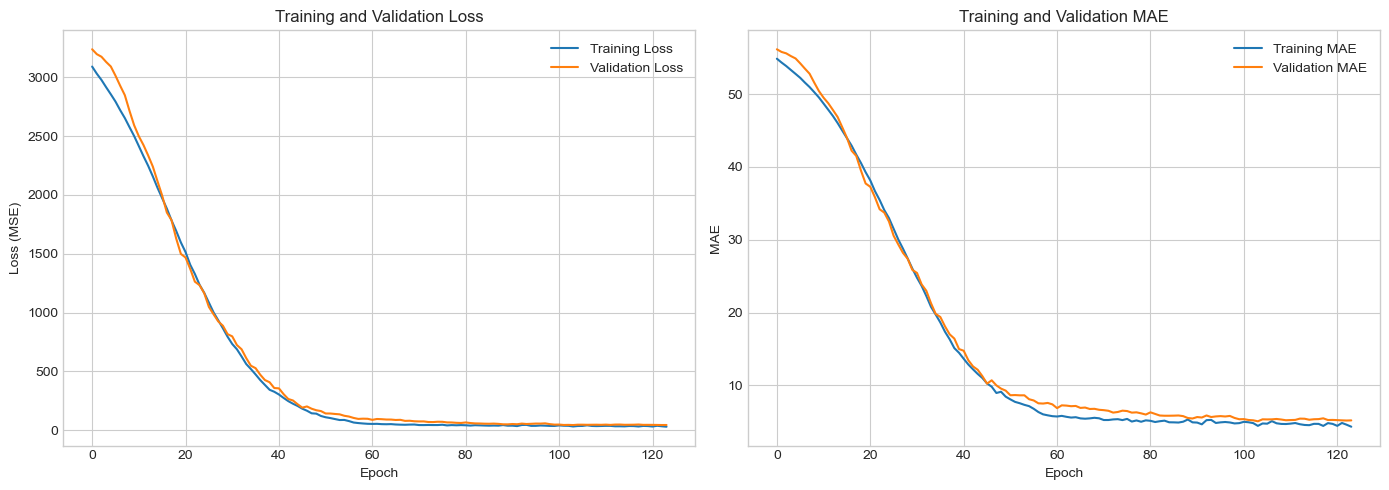

In [35]:
"""Plot training history."""
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training and Validation MAE')
axes[1].legend()

plt.tight_layout()
plt.savefig('nn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

In [36]:
"""Evaluate Neural Network on validation set."""
y_pred_nn = nn_model.predict(X_val_processed, verbose=0).flatten()
results.append(evaluate_model(y_val, y_pred_nn, 'Neural Network'))


Neural Network Results:
  RMSE: 6.6301
  MAE:  5.0677
  R²:   0.4727


### 4.4 Advanced Deep Learning Model with Skip Connections

In [37]:
def build_advanced_nn(input_dim):
    """Build an advanced tabular neural network with skip connections.

    Features:
    - Skip connections (residual connections)
    - Deeper architecture
    - L2 regularization

    Args:
        input_dim: Number of input features.

    Returns:
        keras.Model: Compiled neural network model.
    """
    inputs = layers.Input(shape=(input_dim,))

    # Initial dense block
    x = layers.Dense(
        512,
        kernel_regularizer=keras.regularizers.l2(0.001),
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)

    # Second block with residual connection
    x1 = layers.Dense(
        256,
        kernel_regularizer=keras.regularizers.l2(0.001),
    )(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Dropout(0.3)(x1)

    x1 = layers.Dense(
        256,
        kernel_regularizer=keras.regularizers.l2(0.001),
    )(x1)
    x1 = layers.BatchNormalization()(x1)

    # Skip connection
    x_skip = layers.Dense(256)(x)
    x = layers.Add()([x1, x_skip])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    # Third block
    x = layers.Dense(
        128,
        kernel_regularizer=keras.regularizers.l2(0.001),
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    # Fourth block
    x = layers.Dense(
        64,
        kernel_regularizer=keras.regularizers.l2(0.001),
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)

    # Output
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae'],
    )

    return model


# Build and display advanced model
advanced_nn = build_advanced_nn(X_train_processed.shape[1])
advanced_nn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 95)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │     49,152 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    131,328 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     65,792 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    131,328 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 256)       │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     32,896 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ dropout_7[0][0] 

 Total params: 423,681 (1.62 MB)

 Trainable params: 421,249 (1.61 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [38]:
"""Train advanced neural network model."""
history_advanced = advanced_nn.fit(
    X_train_processed,
    y_train,
    validation_data=(X_val_processed, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

Epoch 1/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 19s 823ms/step - loss: 3070.7615 - mae: 54.3956

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2985.3135 - mae: 53.8996 - val_loss: 3196.1846 - val_mae: 55.7895 - learning_rate: 0.0010


Epoch 2/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2956.6807 - mae: 53.4995

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2883.1917 - mae: 53.0003 - val_loss: 3130.2900 - val_mae: 55.2355 - learning_rate: 0.0010


Epoch 3/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2848.7949 - mae: 52.4964

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2778.4062 - mae: 52.0747 - val_loss: 3033.7913 - val_mae: 54.4274 - learning_rate: 0.0010


Epoch 4/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2752.6726 - mae: 51.6508

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2670.1709 - mae: 51.1353 - val_loss: 2905.5693 - val_mae: 53.3546 - learning_rate: 0.0010


Epoch 5/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2625.7690 - mae: 50.6125

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2606.0823 - mae: 50.5470

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2555.9353 - mae: 50.0962 - val_loss: 2759.2603 - val_mae: 52.0739 - learning_rate: 0.0010


Epoch 6/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2497.5127 - mae: 49.4392

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2487.5471 - mae: 49.4438

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2436.2415 - mae: 48.9564 - val_loss: 2560.7798 - val_mae: 50.1895 - learning_rate: 0.0010


Epoch 7/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2387.5415 - mae: 48.3353

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2363.6365 - mae: 48.2241

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2307.9028 - mae: 47.6650 - val_loss: 2320.4685 - val_mae: 47.7300 - learning_rate: 0.0010


Epoch 8/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2257.5266 - mae: 46.9387

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2239.7717 - mae: 46.9006

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2182.8604 - mae: 46.3201 - val_loss: 2150.4067 - val_mae: 45.8820 - learning_rate: 0.0010


Epoch 9/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2094.5115 - mae: 45.2171

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2093.9473 - mae: 45.3040

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2038.8956 - mae: 44.7225 - val_loss: 1969.6442 - val_mae: 43.7948 - learning_rate: 0.0010


Epoch 10/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1966.7660 - mae: 43.8183

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1966.7520 - mae: 43.8802

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1957.1329 - mae: 43.7705


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1897.8735 - mae: 43.0857 - val_loss: 1748.2239 - val_mae: 41.0535 - learning_rate: 0.0010


Epoch 11/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1855.5442 - mae: 42.4858

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1830.1067 - mae: 42.2577

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1789.4415 - mae: 41.7832 - val_loss: 1725.7329 - val_mae: 40.8088 - learning_rate: 5.0000e-04


Epoch 12/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1761.6085 - mae: 41.3573

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1749.6362 - mae: 41.2425

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1702.2689 - mae: 40.6937 - val_loss: 1670.3043 - val_mae: 40.1080 - learning_rate: 5.0000e-04


Epoch 13/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1689.8059 - mae: 40.3912

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1672.7205 - mae: 40.2834 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1634.2227 - mae: 39.8058 - val_loss: 1632.7524 - val_mae: 39.5952 - learning_rate: 5.0000e-04


Epoch 14/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1610.2811 - mae: 39.3840

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1601.5538 - mae: 39.3350

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1559.7186 - mae: 38.8467 - val_loss: 1581.0295 - val_mae: 38.9382 - learning_rate: 5.0000e-04


Epoch 15/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1538.5629 - mae: 38.4953

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1522.7720 - mae: 38.3487

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1487.6332 - mae: 37.8824 - val_loss: 1455.8141 - val_mae: 37.2325 - learning_rate: 5.0000e-04


Epoch 16/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1444.3140 - mae: 37.3441

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1446.9281 - mae: 37.3549

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1420.4502 - mae: 36.9724 - val_loss: 1372.0693 - val_mae: 36.0463 - learning_rate: 5.0000e-04


Epoch 17/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1400.9955 - mae: 36.5820

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1388.3309 - mae: 36.5035

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1353.7489 - mae: 36.0253 - val_loss: 1353.7683 - val_mae: 35.7626 - learning_rate: 5.0000e-04


Epoch 18/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1313.6287 - mae: 35.3764

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1313.1243 - mae: 35.4333

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1282.1750 - mae: 34.9868 - val_loss: 1309.5469 - val_mae: 35.0460 - learning_rate: 5.0000e-04


Epoch 19/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1252.6503 - mae: 34.4901

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1241.5780 - mae: 34.4331

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1205.6449 - mae: 33.8773 - val_loss: 1208.6577 - val_mae: 33.5227 - learning_rate: 5.0000e-04


Epoch 20/200


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1186.9891 - mae: 33.4637

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1180.9781 - mae: 33.4437 


Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1153.5409 - mae: 33.0118 - val_loss: 1153.9126 - val_mae: 32.7491 - learning_rate: 5.0000e-04


Epoch 20: early stopping


Restoring model weights from the end of the best epoch: 1.


In [39]:
"""Evaluate advanced Neural Network on validation set."""
y_pred_advanced_nn = advanced_nn.predict(X_val_processed, verbose=0).flatten()
results.append(evaluate_model(y_val, y_pred_advanced_nn, 'Advanced Neural Network'))


Advanced Neural Network Results:
  RMSE: 56.5257
  MAE:  55.7895
  R²:   -37.3296


## 5. Model Comparison and Final Predictions

In [40]:
"""Create model comparison summary."""
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
display(results_df)


MODEL COMPARISON SUMMARY


,model,RMSE,MAE,R2
3,Random Forest,5.158134,4.055408,0.680826
6,CatBoost,5.207497,4.128195,0.674688
4,Gradient Boosting,5.271575,4.129713,0.666633
5,XGBoost,5.363997,4.207257,0.654841
2,Elastic Net,5.899572,4.608570,0.582474
1,Ridge Regression,5.901180,4.595718,0.582247
0,Linear Regression,5.932224,4.618753,0.577840
7,Neural Network,6.630107,5.067741,0.472669
8,Advanced Neural Network,56.525744,55.789506,-37.329631


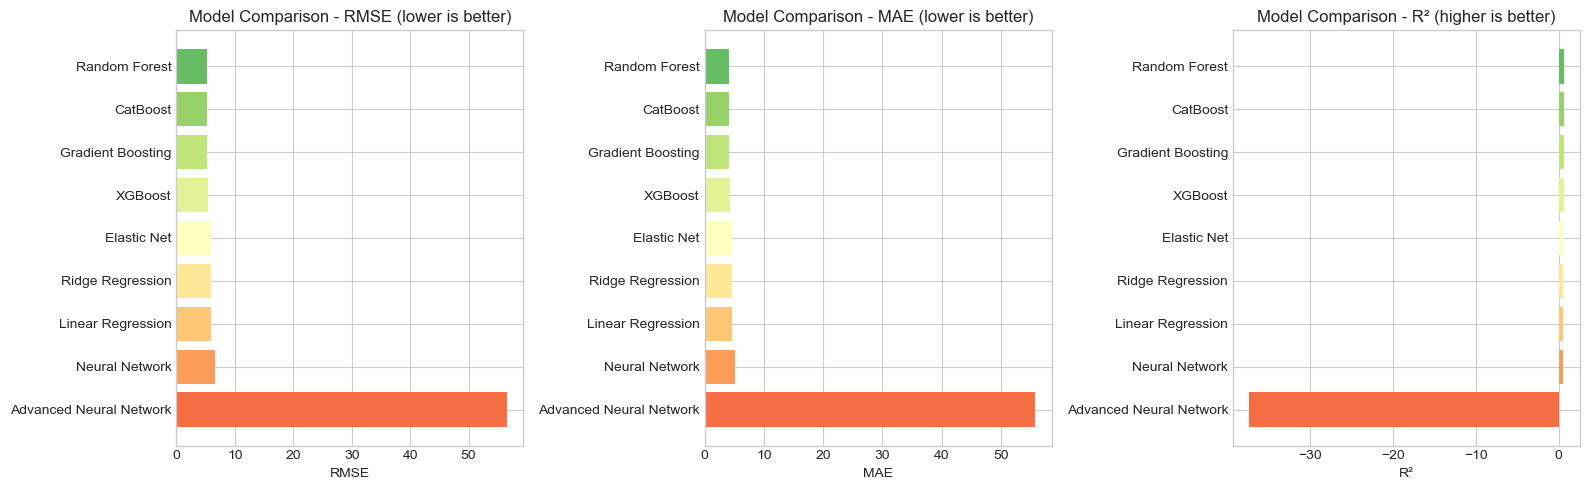

In [41]:
"""Visualize model comparison."""
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Color gradient for performance
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(results_df)))

# RMSE comparison
axes[0].barh(results_df['model'], results_df['RMSE'], color=colors)
axes[0].set_xlabel('RMSE')
axes[0].set_title('Model Comparison - RMSE (lower is better)')
axes[0].invert_yaxis()

# MAE comparison
axes[1].barh(results_df['model'], results_df['MAE'], color=colors)
axes[1].set_xlabel('MAE')
axes[1].set_title('Model Comparison - MAE (lower is better)')
axes[1].invert_yaxis()

# R² comparison
r2_colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(results_df)))
axes[2].barh(results_df['model'], results_df['R2'], color=r2_colors[::-1])
axes[2].set_xlabel('R²')
axes[2].set_title('Model Comparison - R² (higher is better)')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [42]:
"""Identify the best model based on RMSE."""
best_model_name = results_df.iloc[0]['model']
best_rmse = results_df.iloc[0]['RMSE']

print(f"\nBest Model: {best_model_name}")
print(f"Validation RMSE: {best_rmse:.4f}")


Best Model: Random Forest
Validation RMSE: 5.1581


### 5.1 Cross-Validation for Best Models

In [43]:
"""Perform 5-fold cross-validation on top models."""
# Prepare full training data
X_full_processed = preprocessor.fit_transform(X)

# Cross-validate XGBoost
xgb_cv = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
)
xgb_cv_scores = cross_val_score(
    xgb_cv,
    X_full_processed,
    y,
    cv=5,
    scoring='neg_root_mean_squared_error',
)
print(
    f"XGBoost 5-Fold CV RMSE: {-xgb_cv_scores.mean():.4f} "
    f"(+/- {xgb_cv_scores.std():.4f})"
)

# Cross-validate CatBoost
cat_cv = CatBoostRegressor(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    verbose=0,
)
cat_cv_scores = cross_val_score(
    cat_cv,
    X_full_processed,
    y,
    cv=5,
    scoring='neg_root_mean_squared_error',
)
print(
    f"CatBoost 5-Fold CV RMSE: {-cat_cv_scores.mean():.4f} "
    f"(+/- {cat_cv_scores.std():.4f})"
)

# Cross-validate Random Forest
rf_cv = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
rf_cv_scores = cross_val_score(
    rf_cv,
    X_full_processed,
    y,
    cv=5,
    scoring='neg_root_mean_squared_error',
)
print(
    f"Random Forest 5-Fold CV RMSE: {-rf_cv_scores.mean():.4f} "
    f"(+/- {rf_cv_scores.std():.4f})"
)

XGBoost 5-Fold CV RMSE: 5.0116 (+/- 0.1655)


CatBoost 5-Fold CV RMSE: 4.8674 (+/- 0.0678)


Random Forest 5-Fold CV RMSE: 4.8733 (+/- 0.1310)


### 5.2 Generate Final Predictions for Test Set

In [44]:
"""Retrain best models on full training data."""
print("Retraining models on full training data...")

# Fit preprocessor on full training data
X_train_full = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(test_df)

# Train individual models on full data
xgb_final = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
)
xgb_final.fit(X_train_full, y)

cat_final = CatBoostRegressor(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    verbose=0,
)
cat_final.fit(X_train_full, y)

rf_final = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
rf_final.fit(X_train_full, y)

# Neural Network on full data
nn_final = build_tabular_nn(X_train_full.shape[1])
nn_final.fit(X_train_full, y, epochs=100, batch_size=32, verbose=0)

print("Models trained successfully!")

Retraining models on full training data...


Models trained successfully!


In [45]:
"""Generate predictions using weighted ensemble."""
pred_xgb = xgb_final.predict(X_test_processed)
pred_cat = cat_final.predict(X_test_processed)
pred_rf = rf_final.predict(X_test_processed)
pred_nn = nn_final.predict(X_test_processed, verbose=0).flatten()

# Weighted ensemble (weights based on CV performance)
ENSEMBLE_WEIGHTS = {
    'xgb': 0.35,
    'cat': 0.35,
    'rf': 0.20,
    'nn': 0.10,
}

final_predictions = (
    ENSEMBLE_WEIGHTS['xgb'] * pred_xgb +
    ENSEMBLE_WEIGHTS['cat'] * pred_cat +
    ENSEMBLE_WEIGHTS['rf'] * pred_rf +
    ENSEMBLE_WEIGHTS['nn'] * pred_nn
)

print(f"\nPrediction Statistics:")
print(f"Mean: {final_predictions.mean():.2f}")
print(f"Std: {final_predictions.std():.2f}")
print(f"Min: {final_predictions.min():.2f}")
print(f"Max: {final_predictions.max():.2f}")


Prediction Statistics:
Mean: 54.30
Std: 7.31
Min: 40.66
Max: 73.02


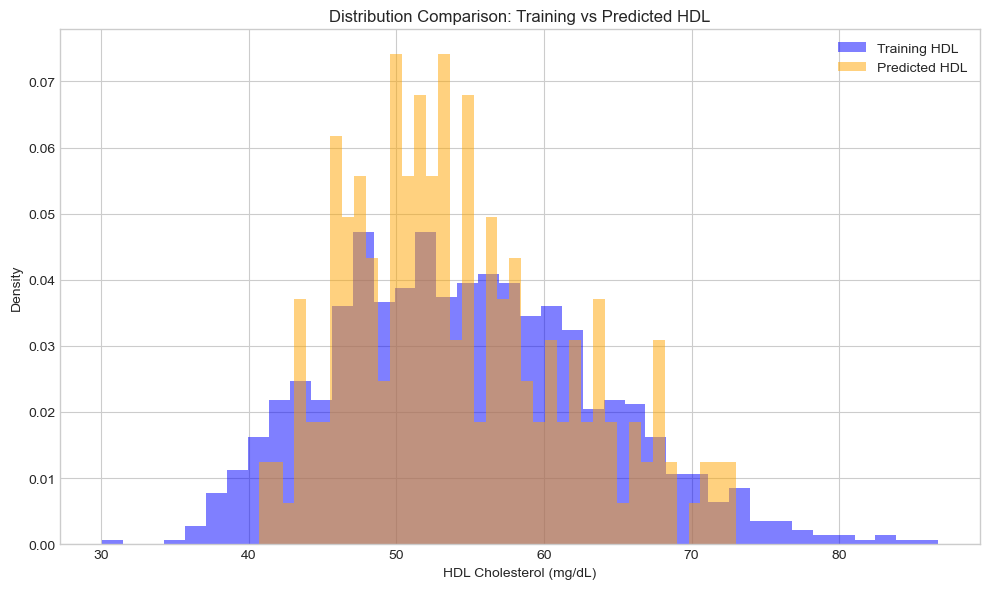

In [46]:
"""Compare prediction distribution with training target distribution."""
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(
    y,
    bins=40,
    alpha=0.5,
    label='Training HDL',
    density=True,
    color='blue',
)
ax.hist(
    final_predictions,
    bins=40,
    alpha=0.5,
    label='Predicted HDL',
    density=True,
    color='orange',
)

ax.set_xlabel('HDL Cholesterol (mg/dL)')
ax.set_ylabel('Density')
ax.set_title('Distribution Comparison: Training vs Predicted HDL')
ax.legend()

plt.tight_layout()
plt.savefig('prediction_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [47]:
"""Save predictions to CSV for submission."""
submission = pd.DataFrame({'pred': final_predictions})
submission.to_csv('pred.csv', index=False)

print("Predictions saved to pred.csv")
print(f"\nSubmission file preview:")
display(submission.head(10))
print(f"\nTotal predictions: {len(submission)}")

Predictions saved to pred.csv

Submission file preview:


,pred
0,48.178994
1,54.463649
2,60.070027
3,46.447970
4,41.483353
5,62.844067
6,44.477164
7,63.772167
8,47.457769
9,54.331328



Total predictions: 200


## 6. Summary and Conclusions

In [48]:
"""Display final summary of the analysis."""
print("=" * 70)
print("HDL CHOLESTEROL PREDICTION - FINAL SUMMARY")
print("=" * 70)

print("\n1. DATA OVERVIEW:")
print(f"   - Training samples: {len(train_df)}")
print(f"   - Test samples: {len(test_df)}")
print(f"   - Number of features: {X.shape[1]}")
print(f"   - Target mean: {y.mean():.2f} mg/dL")
print(f"   - Target std: {y.std():.2f} mg/dL")

print("\n2. KEY FINDINGS FROM EDA:")
print(f"   - Features with >50% missing: {(missing_pct > 50).sum()}")
print(
    f"   - Target distribution is approximately normal "
    f"(skewness: {train_df[TARGET_COL].skew():.3f})"
)
print("   - Strong negative correlation with body measures (BMI, waist)")

print("\n3. MODEL PERFORMANCE (Validation RMSE):")
for _, row in results_df.head(5).iterrows():
    print(f"   - {row['model']}: {row['RMSE']:.4f}")

print("\n4. FINAL MODEL:")
print("   - Weighted ensemble of XGBoost, CatBoost, Random Forest, and NN")
print(
    f"   - Weights: XGBoost ({ENSEMBLE_WEIGHTS['xgb']}), "
    f"CatBoost ({ENSEMBLE_WEIGHTS['cat']}), "
    f"RF ({ENSEMBLE_WEIGHTS['rf']}), "
    f"NN ({ENSEMBLE_WEIGHTS['nn']})"
)

print("\n5. OUTPUT FILES:")
print("   - pred.csv: Final predictions for submission")
print("   - Various PNG files with visualizations")

print("\n" + "=" * 70)

HDL CHOLESTEROL PREDICTION - FINAL SUMMARY

1. DATA OVERVIEW:
   - Training samples: 1000
   - Test samples: 200
   - Number of features: 95
   - Target mean: 54.73 mg/dL
   - Target std: 9.01 mg/dL

2. KEY FINDINGS FROM EDA:
   - Features with >50% missing: 0
   - Target distribution is approximately normal (skewness: 0.376)
   - Strong negative correlation with body measures (BMI, waist)

3. MODEL PERFORMANCE (Validation RMSE):
   - Random Forest: 5.1581
   - CatBoost: 5.2075
   - Gradient Boosting: 5.2716
   - XGBoost: 5.3640
   - Elastic Net: 5.8996

4. FINAL MODEL:
   - Weighted ensemble of XGBoost, CatBoost, Random Forest, and NN
   - Weights: XGBoost (0.35), CatBoost (0.35), RF (0.2), NN (0.1)

5. OUTPUT FILES:
   - pred.csv: Final predictions for submission
   - Various PNG files with visualizations



## References

1. NHANES Program Overview: https://www.cdc.gov/nchs/nhanes/about/index.html
2. ASA South Florida Student Data Challenge: https://luminwin.github.io/ASASF/
3. XGBoost Documentation: https://xgboost.readthedocs.io/
4. CatBoost Documentation: https://catboost.ai/docs/
5. TensorFlow/Keras Documentation: https://www.tensorflow.org/api_docs